# Travelling salesman problem

Specifications of the problem : [https://en.wikipedia.org/wiki/Travelling_salesman_problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

## Librairies

Here's all the libraries needed.

In [298]:
from itertools import combinations, accumulate
import pandas as pd
import numpy as np
from icecream import ic
from geopy.distance import geodesic
from matplotlib import pyplot as plt

## Initialization

We extract the cities from the file and create a matrix to store the distance between each city.

In [299]:
FILE = 'cities/us.csv' # Modify this path to select the problem

MAX_STEPS = 200_000

CITIES = pd.read_csv(FILE, header=None, names=['name', 'lat', 'lon'])

SIZE = len(CITIES)

DIST_MATRIX = np.zeros((SIZE, SIZE))

# Compute the matrix of distances in km
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

Let's also define the cost of a solution by computing the total distance.

In [300]:
def cost(tsp: list) -> int:
    """Return the cost of a tsp solution"""
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]

    return tot_cost

Finally, we define a function that will ensure that the solution is indeed a Hamiltonian cycle by checking that :
- It's a cycle
- It visit each vertex exactly once

In [301]:
def valid(tsp: list) -> bool:
    """Return true if the given tsp is valid"""

    # Check if the solution is a cycle
    if tsp[0] != tsp[SIZE]:
        return False

    # Check that the vertex is visited once
    already_visited = list()
    for i in range(SIZE):
        city = tsp[i]

        if city in already_visited:
            return False

        already_visited.append(city)

    # Check that all vertex is visited
    if len(already_visited) != SIZE:
        return False

    return True

## First greedy algorithm

At first, I just wanted a working solution in order to upgrade it step by step. 

So I define a fist greedy function that solves a tsp by going always the closest city.

In [302]:
def greedy_tsp(dist_matrix) -> list :
    """Function that solves a tsp problem on a given matrix of distances using a greedy approach"""
    dist = dist_matrix.copy()
    city = 0
    tsp = list()

    while not np.all(dist == np.inf):
        tsp.append(city)
        dist[:, city] = np.inf # don't select this city anymore
        closest = np.argmin(dist[city]) # select the closest city
        city = closest
    
    tsp.append(tsp[0]) # Add the first city and close the hamiltonian cycle
    return tsp

Let's see what it does.

In [303]:
tsp = greedy_tsp(DIST_MATRIX)

print(f"The solution is {'not ' if not valid(tsp) else ''}valid, total cost : {cost(tsp=tsp)}")
    

The solution is valid, total cost : 48050.025864461386


As we can see, this is pretty fast, indeed the temporal complexity of the algorithm is pretty much in $O(N^2)$, where N is the number of cities.

It has also a good result, not the best one because the algorithm doesn't care about the last path.

## First Hill climbing

Let's try to achieve a better result by using hill climbing.

It's important to note that in my hill climbing algorithms, I select a random city as my first and final step.

When performing mutations, I never touch them. It's simpler in order to always have a cycle.


Let's first define the fitness to be the opposite of the cost, in order to have a gradient ascent.

In [304]:
def fitness(tsp: list) -> int:
    return -cost(tsp)

We can then define our first tweak function that will simply swap two points in a given path.

In [305]:
def swap(tsp: list) -> list:
    """Perform a random swap between two element in a list"""
    # Select two random indexes
    first_index = np.random.randint(1, SIZE - 1) # Never update the first and last element to keep the cycle
    second_index = np.random.randint(1, SIZE - 1)

    # Swap elements
    tmp = tsp[first_index]
    tsp[first_index] = tsp[second_index]
    tsp[second_index] = tmp
    
    return tsp

def swap_mutation(tsp: list) -> list:
    """Tweak function that will perform a swap between two elements in the tsp"""
    new_tsp = tsp.copy()

    swap(new_tsp)

    return new_tsp

Finally, we can define our hill climbing. It will use the simplest mutation for **fixed-length integer array of one-time items** representation, which is swap mutation.

In [306]:
def swap_mutation_hill_climbing_tsp() -> tuple[list, list[int]]:
    """Returns a solution of a tsp by using hill climbing with swap mutation"""
    # Create a first random solution
    solution = list(range(SIZE))
    np.random.shuffle(solution)
    solution.append(solution[0]) # Add the first city and close the hamiltonian cycle

    fitness_solution = fitness(solution) 
    history = [fitness_solution]

    for _ in range(MAX_STEPS):
        # Tweak the current solution
        test_solution = swap_mutation(solution)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution)

        # Select the new solution if it's better
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution


    return solution, history

Let's run it and see if it improve.

The solution is valid, total cost : 143961.30893554853


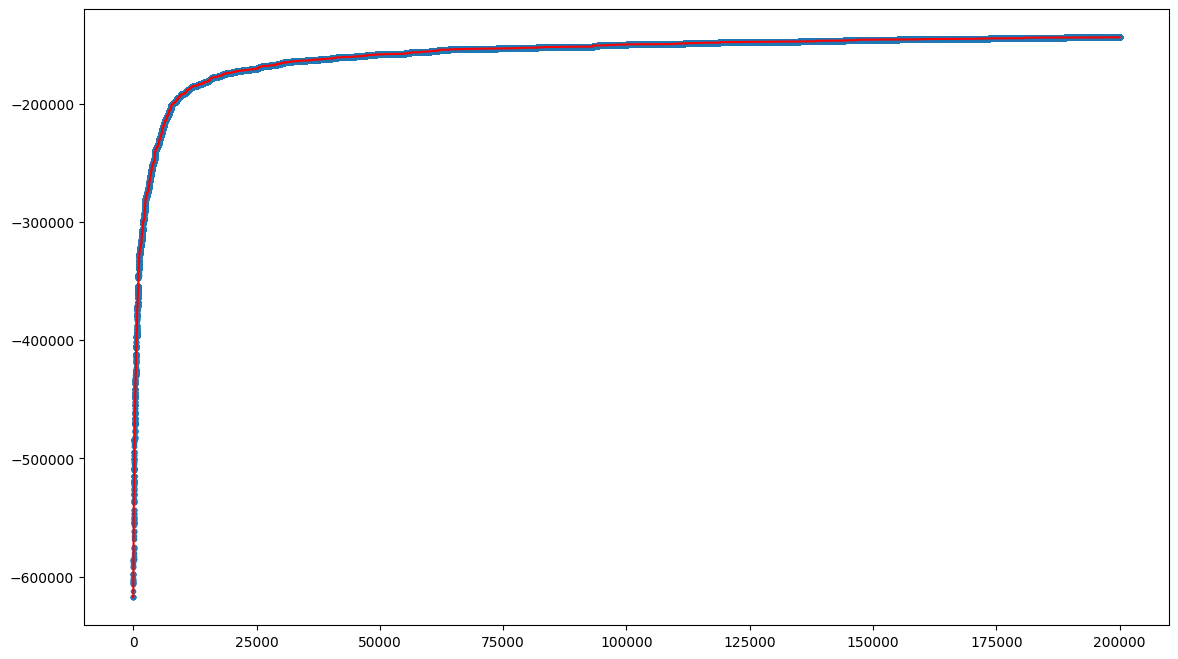

In [307]:
# Perform algorithm
tsp, history = swap_mutation_hill_climbing_tsp()

# Show results
print(f"The solution is {'not ' if not valid(tsp) else ''}valid, total cost : {cost(tsp=tsp)}")

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

This is almost two times worse than the greedy one, but it is still a great starting point for our hill climbing algorithm, let's try to improve it.

## Scramble Mutation

Let's add a way to balance exploration and exploitation by having a kind of strength in the tweak function.

We can use **Scramble Mutation** and use the number of selected alleles to have this strength.

In this way, we can perform exploration at the beginning, and then focus more on exploitation of a solution.

In [308]:
def scramble_mutation(tsp: list, n: int) -> list:
    """Tweak function that will select strength random indexes and shuffle them"""
    new_tsp = tsp.copy()

    # Just perform a swap if n is one
    if n == 1:
        return swap(new_tsp)

    # Check boundaries
    if n > SIZE:
        n = SIZE

    # Select n unique indexes
    indexes = set(np.random.randint(1, SIZE - 1, size=n))
    
    # Get the values of thoses selected indexes
    values_to_scramble = [new_tsp[i] for i in indexes]

    np.random.shuffle(values_to_scramble)

    # Replace them in the solution
    for i, scrambled_value in zip(indexes, values_to_scramble):
        new_tsp[i] = scrambled_value

    return new_tsp

Let's also define a new hill climbing algorithm to use it. It will use the 1/5 success rule :
- If we have more than one success over 5 -> increase the number of scramble
- If we have less than one success over 5 -> decrease the number of scramble

In [ ]:
def scramble_mutation_hill_climbing_tsp() -> tuple[list, list[int]]:
    """Returns a solution of a tsp by using hill climbing with dynamic scramble mutation"""
    # Create a first random solution
    solution = list(range(SIZE))
    np.random.shuffle(solution)
    solution.append(solution[0]) # Add the first city and close the hamiltonian cycle

    fitness_solution = fitness(solution)
    history = [fitness_solution]

    # Initialization of the success rule
    n = int(SIZE/8)
    succes = 0

    for i in range(MAX_STEPS):
        # Every five iterations if we have more than one success increase n else if we have less than one, decrease it
        if i%5:
            if succes > 1:
                n += 1
            elif succes < 1 and n > 1:
                n -= 1
            succes = 0

        # Tweak the current solution
        test_solution = scramble_mutation(solution, n)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution)

        # Select the new solution if it's better
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution
            succes += 1

    return solution, history

Let's see what it can do.

The solution is valid, total cost : 130790.79350336846


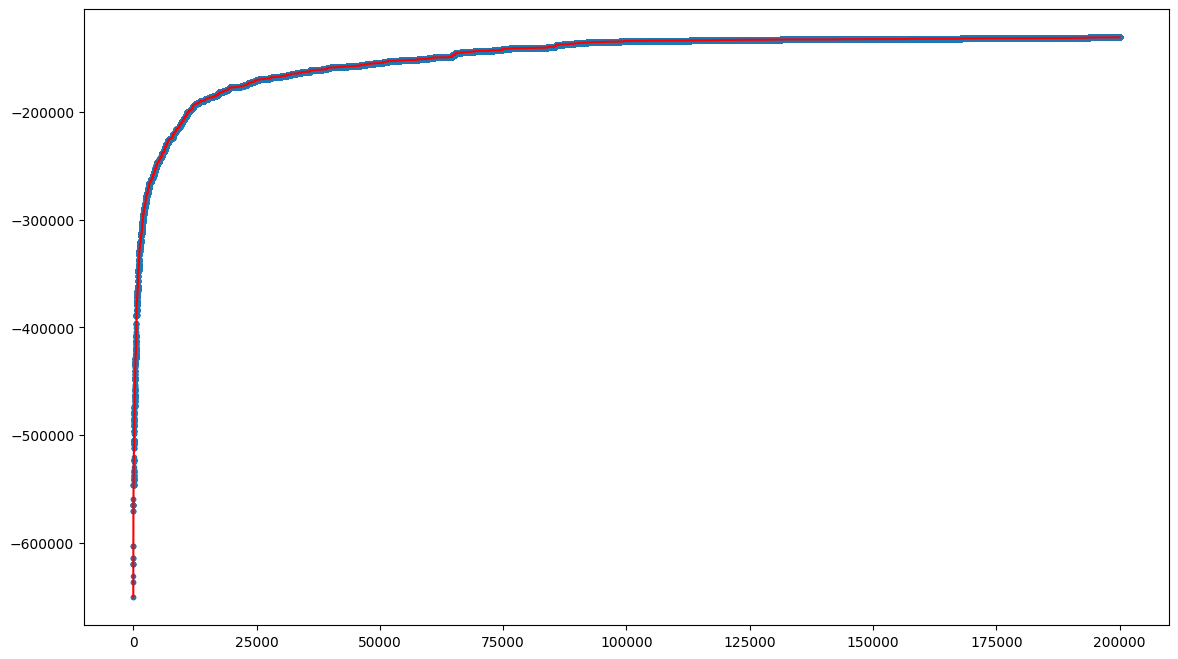

In [ ]:
# Perform algorithm
tsp, history = scramble_mutation_hill_climbing_tsp()

# Show results
print(f"The solution is {'not ' if not valid(tsp) else ''}valid, total cost : {cost(tsp=tsp)}")

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

This new version is a bit better, we have more exploration at the begining, and more exploitation at the end.

But the issue is that we are only looking for one local optimum even if it's a bad one.